# Описание заданий
    1. Проведите разведочный анализ займов в разрезе рейтингов
    • Совет - попробуйте использовать библиотеку plotly. Она отлично подходит для быстрой визуализации

    2. Проиллюстрируйте как менялось отношение Non-performing займов к общей выдаче по полю amount до сегодняшнего дня
    • К NPL платежам будем относить overdue_statuses = ['overdue','potential default', 'defaulted']
    • Будем считать, что займы становятся просроченными безвозвратно.
    • Будем считать, что в момент возникновения просроченного платежа в NPL уходит вся оставшаяся сумма займа.  

    3. * Проведите когортный анализ дефолтности в разрезе месяца выдачи займа 
    • Ушедшими в дефолт будем считать платежи в статусе status == "defaulted"
    • Сумму дефолта по когорте считать накопленным итогом от месяца к месяцу

    4. Напишите аналитический вывод на основании проделанной вами работы
    • Постарайтесь выделить один главный и два дополнительных пункта. Этого будет достаточно :)
    
___

Описание данных

- `id` - Идентификатор займа
- `number` - Порядковый номер платежа
- `payment_date` - Дата платежа
- `status` - Статус платежа
- `amount` - Сумма платежа
- `start_date` - Дата взятия займа
- `loan_rating_int` - Рейтинг займа
- `loan_status_str` - Статус займа
- `restruct_status` - Статус реструктуризации
- `auto_approval` - Был ли займ одобрен автоматически
- `borrower_issue_class` - Класс заемщика на момент взятия займа

### Импорт библиотек

In [86]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
%matplotlib inline

import ydata_profiling

import datetime

from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:70% !important; }</style>"))

### Чтение файла

In [87]:
df = pd.read_csv('loan_data.csv')

In [88]:
#ydata_profiling.ProfileReport(df, explorative=True).to_widgets()

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71025 entries, 0 to 71024
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71025 non-null  int64  
 1   number                71025 non-null  int64  
 2   payment_date          70981 non-null  object 
 3   status                71025 non-null  object 
 4   amount                71025 non-null  float64
 5   start_date            71025 non-null  object 
 6   loan_rating_int       71025 non-null  int64  
 7   loan_status_str       71025 non-null  object 
 8   restruct_status       71025 non-null  object 
 9   auto_approval         71025 non-null  object 
 10  borrower_issue_class  71025 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 6.0+ MB


Изменим тип данных столбцов с датами и приведем их к более удобной форме

In [90]:
df['payment_date'] = pd.to_datetime(df['payment_date'])
df['start_date'] = pd.to_datetime(df['start_date'])

### Разведочный анализ займов в разрезе рейтингов

#### Отличия рейтингов в разрезе платежей

Прежде чем анализировать сами рейтинги, хочу посмотреть, чем отличаются они друг от друга в разрезе займов и платежей

Сначала посмотрим на разницу в разрезе всего займа

In [91]:
group_id = df.groupby(
    ['id',
     'loan_rating_int',
     'loan_status_str',
     'restruct_status',
     'auto_approval',
     'borrower_issue_class'])['amount'].agg({'sum', 'mean', 'median', 'count'}).reset_index()

In [92]:
group_id.head()

,id,loan_rating_int,loan_status_str,restruct_status,auto_approval,borrower_issue_class,count,mean,median,sum
0,12436,10,active,no restruct,No auto-approve,4. platinum,23,5.177199e+05,516209.0,11907557.0
1,12460,8,active,no restruct,No auto-approve,2. silver,24,2.469685e+05,245666.5,5927243.0
2,12479,14,active,restruct,No auto-approve,2. silver,25,1.010639e+05,129294.0,2526597.6
3,12483,13,closed,no restruct,No auto-approve,2. silver,5,1.727711e+06,414803.0,8638554.0
4,12484,10,active,no restruct,No auto-approve,2. silver,24,2.479826e+05,247363.0,5951583.0


Теперь полученные данные сагрегируем по рейтингу

In [93]:
group_id_rate = group_id.groupby('loan_rating_int')['sum'].agg({'sum', 'mean', 'median', 'count'}).reset_index()

In [94]:
group_id_rate

,loan_rating_int,count,mean,median,sum
0,1,4,5.001756e+06,4063120.50,2.000702e+07
1,2,4,8.203988e+05,675613.15,3.281595e+06
2,3,32,4.833659e+06,3078789.50,1.546771e+08
3,4,23,3.441564e+06,2549080.30,7.915598e+07
4,5,35,3.835205e+06,2193788.00,1.342322e+08
5,6,76,4.059511e+06,3202489.70,3.085229e+08
6,7,214,4.234636e+06,2631139.00,9.062121e+08
7,8,121,3.772016e+06,2324369.70,4.564139e+08
8,9,285,3.929668e+06,2716839.00,1.119956e+09
9,10,251,3.451106e+06,2286466.10,8.662276e+08


In [95]:
group_id_rate_long = group_id_rate.melt(
    id_vars='loan_rating_int',
    value_vars=['median', 'mean'],
    var_name='metric',
    value_name='value')

In [96]:
sns.set_style("darkgrid")

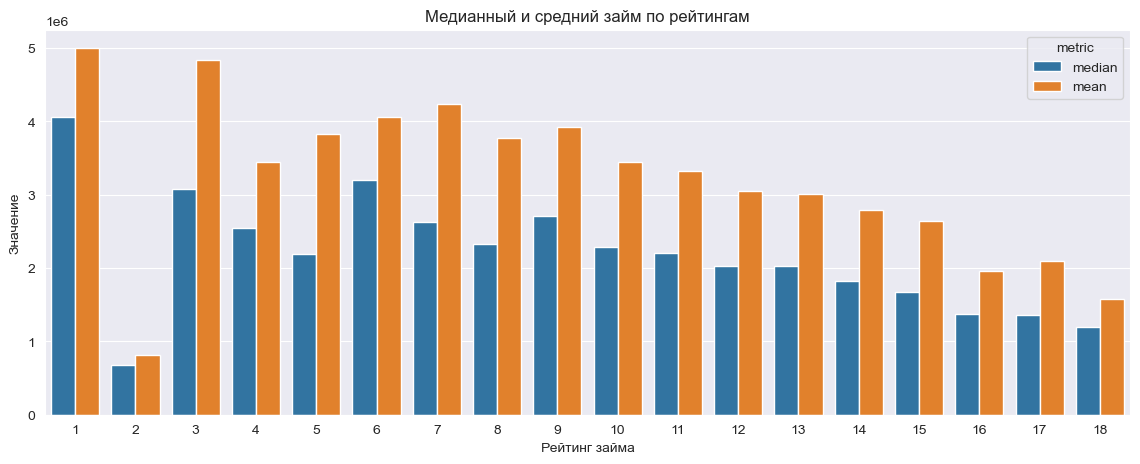

In [97]:
plt.figure(figsize=(14, 5))
sns.barplot(data=group_id_rate_long, x='loan_rating_int', y='value', hue='metric')

plt.title('Медианный и средний займ по рейтингам')
plt.xlabel('Рейтинг займа')
plt.ylabel('Значение')

plt.show()

Теперь посмотрим на разницу в рейтингах в разрезе платежа

In [98]:
group_rating = df.groupby('loan_rating_int')['amount'].agg({'sum', 'mean', 'median', 'count'}).reset_index()

In [99]:
group_rating_long = group_rating.melt(
    id_vars='loan_rating_int',
    value_vars=['median', 'mean'],
    var_name='metric',
    value_name='value')

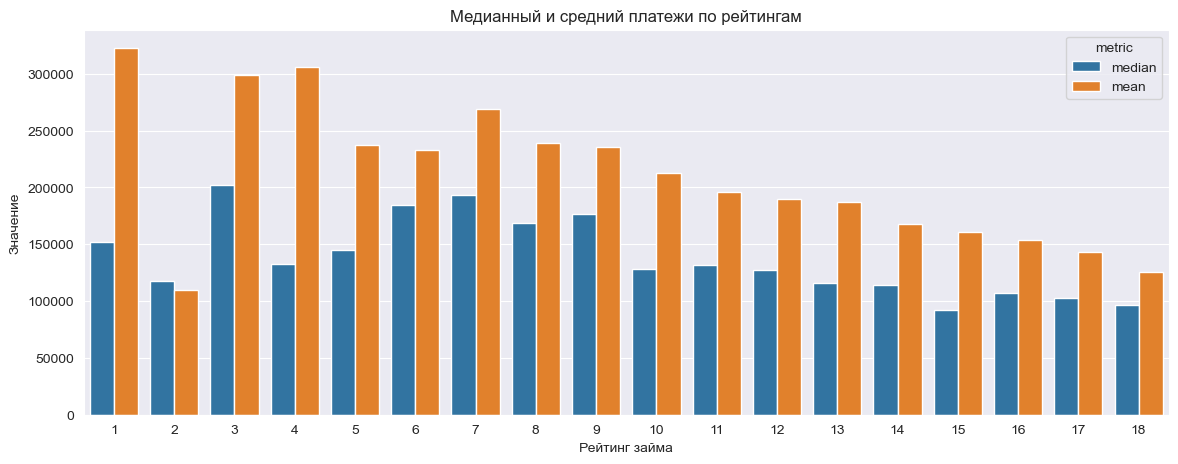

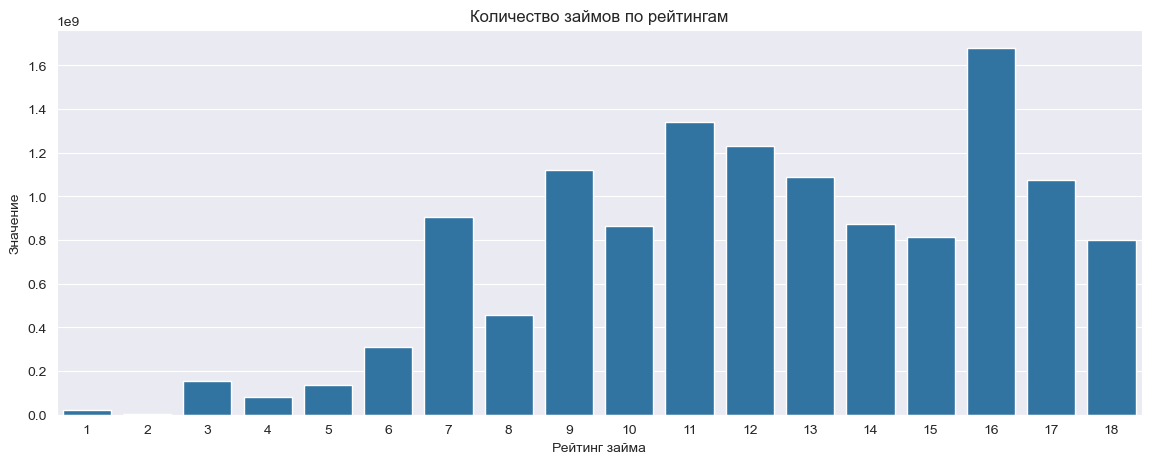

In [100]:
plt.figure(figsize=(14, 5))
sns.barplot(data=group_rating_long, x='loan_rating_int', y='value', hue='metric')

plt.title('Медианный и средний платежи по рейтингам')
plt.xlabel('Рейтинг займа')
plt.ylabel('Значение')

plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(data=group_rating, x='loan_rating_int', y='sum')

plt.title('Количество займов по рейтингам')
plt.xlabel('Рейтинг займа')
plt.ylabel('Значение')

plt.show()

Смотря на графики, можно сделать выводы:
- чем ниже рейтинг, тем ниже среднее и медианное значения займа/платежа.
- количество низкорейтинговых займов больше, чем высокорейтинговых.

Следовательно, на рейтинг займа большое влияние оказывает сумма займа/платежа. Также это подтверждается разбросом между медианой и средней - в более высоких рейтингах разница больше, чем в низких, т.к. средняя больше подвержена выбросам
___

Напишем функцию, которая поможет рассмотреть структуру рейтингов по каждой категории - `status`, `loan_status_str`, `restruct_status`, `auto_approval`, `borrower_issue_class`.

In [101]:
def df_plot(index, column):
    (
        df.pivot_table(
            index=index,
            columns=column,
            values='id',
            aggfunc='count')
        .plot(
            kind='bar',
            stacked=True,
            figsize=(14, 9),
            fontsize=10)
    )
    
    plt.title(f'Структура рейтингов в разрезе столбца {column}')
    plt.xlabel('Рейтинг займа')
    plt.ylabel('Количество платежей')

    plt.show()

#### `status`

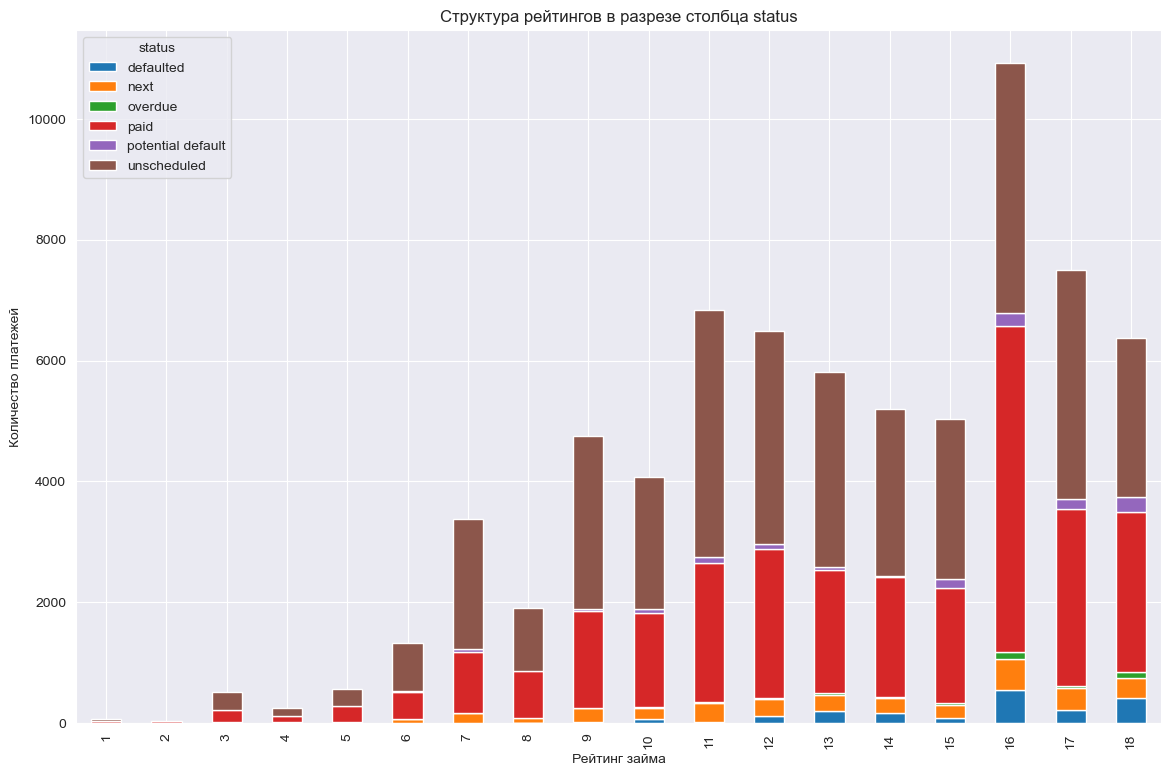

In [102]:
df_plot('loan_rating_int', 'status')

Подавляющее большинство платежей в каждом рейтинге плановое (paid) и внеплановое (unscheduled).

Также есть корреляция между рейтингом и "плохими" займами, имеющие статус 'overdue','potential default', 'defaulted': чем ниже рейтинг, тем чаще встречаются "плохие" займы. Большинство просрочек/потенциального дефолта/дефолта встречаются в **16-18** рейтинге.

#### `loan_status_str`

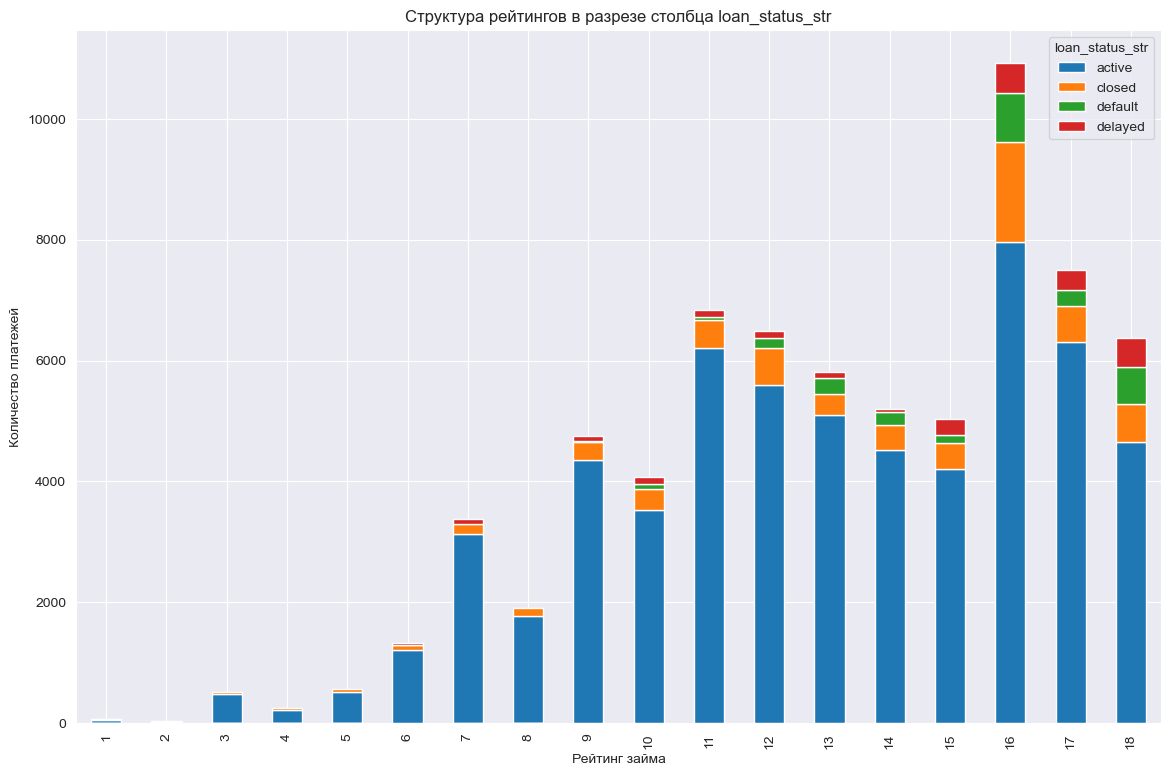

In [103]:
df_plot('loan_rating_int', 'loan_status_str')

Подавляющее большинство займов имеют статус active.

Еще одно наблюдение: чем ниже рейтинг займа, тем чаще встречается статус default (опять выделяются 16 и 18 рейтинги). Несмотря на малочисленность, у займов из топ-8 рейтинга только 3 платежа с подобным статусом.

#### `restruct_status`

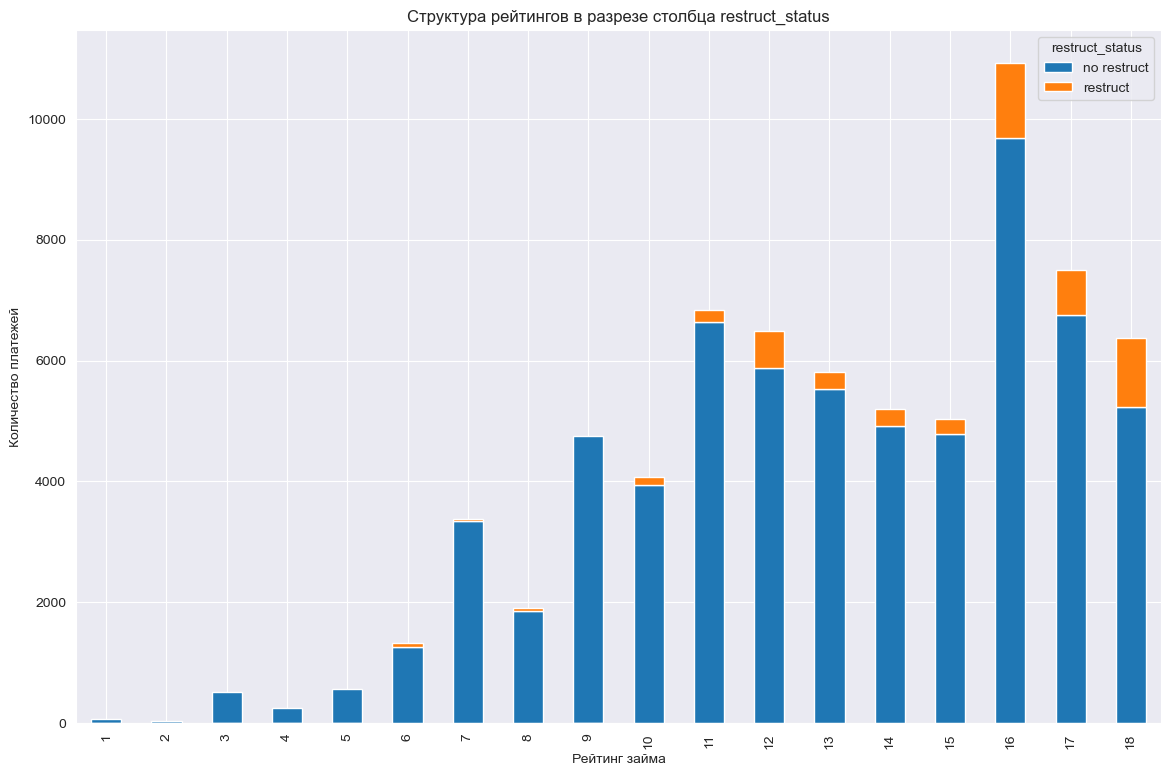

In [104]:
df_plot('loan_rating_int', 'restruct_status')

Похожая картина и со статусом реструктуризации - чем ниже рейтинг, тем чаще встречаются подобные займы. Но подавляющее большинство из всех заемщиков не прибегает к такой опции

#### `auto_approval`

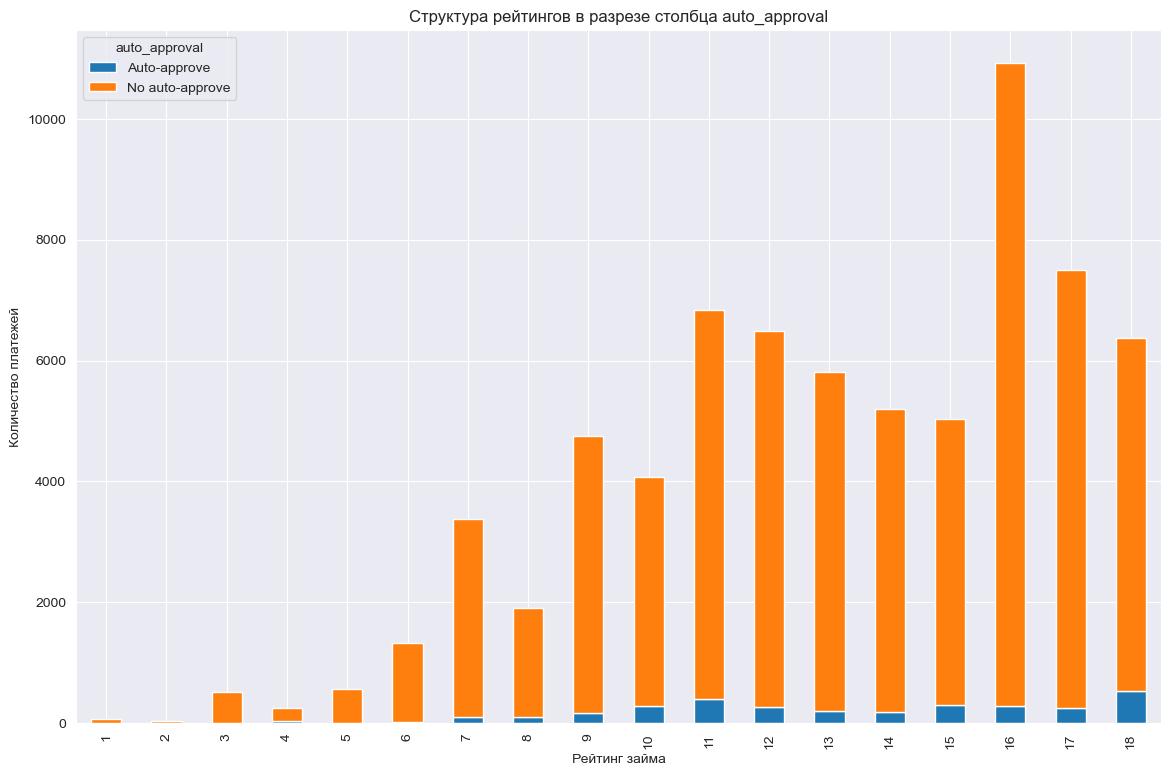

In [105]:
df_plot('loan_rating_int', 'auto_approval')

Низкорейтинговые займы автоматически одобряются чаще, чем высокорейтинговые. Думаю, это связано в первую очередь с суммой займа: ниже сумма - выше вероятность автоматического одобрения (т.е. меньше рисков для финучреждения)

#### `borrower_issue_class`

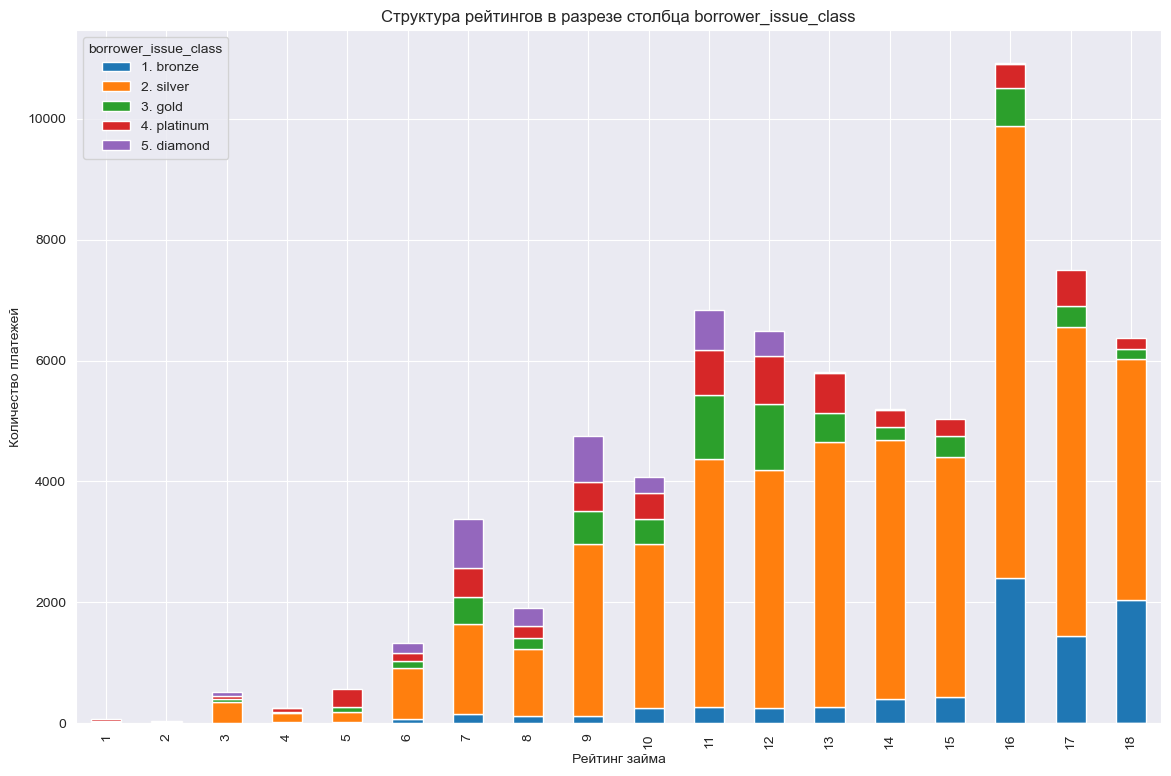

In [106]:
df_plot('loan_rating_int', 'borrower_issue_class')

- Самый частый класс заемщика - **silver**. Имеется буквально в каждом рейтинге/группе.
- Подавляющее большинство **bronze** приходится на самые низкие уровни рейтинга - 16-18
- **gold** чаще всего встречается в 11-12 группе
- **platinum** не имеет таких же выраженных групп, как три предыдущие категории, но чаще встречается в 11-13 группах
- **diamond** чаще встречается в 7, 9, 11 группах (интересно, что это не смежные рейтинги). Наличие в 13+ рейтингах крайне редко, как и в 1-5.

В целом, можно сказать: чем статусней заемщик, тем выше рейтинг у его заема (малочисленность **platinum** и **diamond** в топовых рейтингах можно объяснить маленькой выборкой в этих самых рейтингах).
___

### Non-performing займы

Проиллюстрируйте как менялось отношение Non-performing займов к общей выдаче по полю amount до сегодняшнего дня
- К NPL платежам будем относить overdue_statuses = ['overdue','potential default', 'defaulted']
- Будем считать, что займы становятся просроченными безвозвратно.
- Будем считать, что в момент возникновения просроченного платежа в NPL уходит вся оставшаяся сумма займа.  

In [107]:
overdue_statuses = ['overdue', 'potential default', 'defaulted']

В ходе исследования обнаружил:
- после статуса **overdue** часто идет статус **next** (не относится к NPL), за которым идет **defaulted** или **potential default**. Т.е. некоторые nextы надо отнести к NPL - так говорит условие "*Будем считать, что в момент возникновения просроченного платежа в NPL уходит вся оставшаяся сумма займа*"

Вводим новый столбец `npl`

In [108]:
df['npl'] = df['status'].isin(overdue_statuses)

In [109]:
# Обновление статуса is_npl для последующих платежей после возникновения просроченного платежа
for i in range(1, len(df)):
    if df.loc[i-1, 'status'] in overdue_statuses[0]:
        df.loc[i, 'npl'] = True

Группируем NPL-платежи по датам

In [110]:
# Рассчитываем общую сумму займов на каждую дату
date_npl_amount = df[df['npl']].groupby('payment_date')['amount'].sum().reset_index()

Группируем общие платежи по датам

In [111]:
date_amount = df.groupby('payment_date')['amount'].sum().reset_index()

Аккумулируем платежи

In [112]:
date_amount['cum_amount'] = date_amount['amount'].cumsum()

In [113]:
date_npl_amount['cum_amount'] = date_npl_amount['amount'].cumsum()

In [114]:
date_npl_amount.head()

,payment_date,amount,cum_amount
0,2023-03-30 03:00:00,235858.0,235858.0
1,2023-04-05 03:00:00,1715220.0,1951078.0
2,2023-04-09 03:00:00,317581.4,2268659.4
3,2023-04-10 03:00:00,305875.0,2574534.4
4,2023-04-30 03:00:00,268188.0,2842722.4


Объединим данные по дате. Используем outer, чтобы все даты из обоих дф попали в новый датафрейм

In [115]:
merged_df = pd.merge(
    date_amount,
    date_npl_amount,
    on='payment_date',
    how='outer',
    suffixes=('_total', '_npl'))

Заполняем нулями пустые значения, которые образовались в столбцах amount_npl и cum_amount_npl при мердже, затем по новой применим cumsum и вычислим долю NPL платежей

In [116]:
merged_df['amount_npl'] = merged_df['amount_npl'].fillna(0)
merged_df['cum_amount_npl'] = merged_df['amount_npl'].cumsum()
merged_df['npl_ratio, %'] = round(merged_df['cum_amount_npl'] / merged_df['cum_amount_total'] * 100, 3)

Теперь отфильтруем данные, т.к. в задании указано *Проиллюстрируйте как менялось отношение Non-performing займов к общей выдаче по полю amount до* **сегодняшнего дня**

In [117]:
today = pd.to_datetime(datetime.date.today())

Фильтруем данные до сегодняшнего дня

In [118]:
filtered_df = merged_df[merged_df['payment_date'] <= today]

In [119]:
filtered_df.tail()

,payment_date,amount_total,cum_amount_total,amount_npl,cum_amount_npl,"npl_ratio, %"
658,2024-11-22 03:00:00,5250833.70,9.804905e+09,204565.0,394969896.6,4.028
659,2024-11-23 03:00:00,9722986.20,9.814628e+09,534442.8,395504339.4,4.030
660,2024-11-24 03:00:00,10368169.30,9.824996e+09,425809.4,395930148.8,4.030
661,2024-11-25 03:00:00,20240773.71,9.845237e+09,1602198.7,397532347.5,4.038
662,2024-11-26 03:00:00,11174753.20,9.856412e+09,395434.3,397927781.8,4.037


Столбец npl_ratio показывает отношение Non-performing займов к общей выдаче.
___
Нарисуем график

In [120]:
filtered_df['payment_date'] = pd.to_datetime(filtered_df['payment_date'])

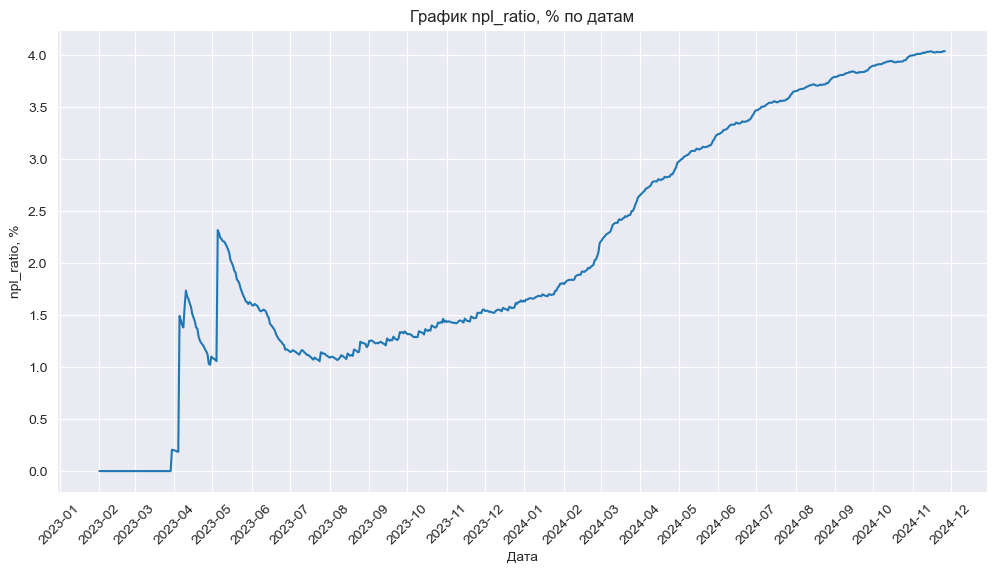

In [121]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='payment_date', y='npl_ratio, %')

plt.title('График npl_ratio, % по датам')
plt.xlabel('Дата')
plt.ylabel('npl_ratio, %')

plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.show()

До июля 2023-го график график ведет себя нестабильно. Но вот начиная с лета доля NPL растет - с 1.1% в 08.23 до ~4% на сегодняшний день.

### Когортный анализ

Проведите когортный анализ дефолтности в разрезе месяца выдачи займа 
- Ушедшими в дефолт будем считать платежи в статусе status == "defaulted"
- Сумму дефолта по когорте считать накопленным итогом от месяца к месяцу
___
Введем новый признак - `new_status`. Обозначим в нем дефолтные позиции и все остальные. Также возьмем условие с прошлого задания - отфильтруем данные по сегодняшний день.

In [122]:
df = df[df['payment_date'] <= today]
df['new_status'] = df['status'].apply(lambda x: 'defaulted' if x == 'defaulted' else 'other')

Обозначим месячные когорты

In [123]:
df['start_month'] = pd.to_datetime(df['start_date']).dt.to_period('M').astype(str)
df['payment_month'] = pd.to_datetime(df['payment_date']).dt.to_period('M').astype(str)

Проиндексируем когорты и платящие месяцы

In [124]:
cohort_map = {cohort: idx + 1 for idx, cohort in enumerate(df['payment_month'].unique())}
cohort_map[0] = '2023-01'

Присвоим каждой когорте и месяцу платежа свой индекс

In [125]:
df['start_month_id'] = df['start_month'].map(cohort_map)
df['payment_month_id'] = df['payment_month'].map(cohort_map)
df['cohort_index'] = df['payment_month_id'] - df['start_month_id'] # определяет разницу между выдачей займа и n-го платежа

In [126]:
#Агрегируем по статусу платежа и когортам
#df_pivot_cohort_x = df.pivot_table(index=['start_month', 'new_status'], columns='cohort_index', values='amount', aggfunc='sum')

Считаем кумулятивные платежи разного статуса по когортам и месяцам

In [127]:
df_cohort = df.pivot_table(
    index=['start_month', 'new_status'],
    columns='payment_month',
    values='amount',
    aggfunc='sum').cumsum(axis=1)

In [128]:
df_cohort.head(10)

payment_month               2023-02      2023-03       2023-04       2023-05  \
start_month new_status                                                         
2023-01     defaulted           NaN          NaN           NaN  3.772150e+06   
            other       35210008.98  64347409.93  9.656253e+07  1.369600e+08   
2023-02     defaulted           NaN          NaN           NaN           NaN   
            other        4502180.70  46178758.48  1.062586e+08  1.467675e+08   
2023-03     defaulted           NaN          NaN           NaN           NaN   
            other               NaN   5708112.00  5.403466e+07  1.106392e+08   
2023-04     defaulted           NaN          NaN           NaN           NaN   
            other               NaN          NaN  1.287699e+06  5.544821e+07   
2023-05     defaulted           NaN          NaN           NaN           NaN   
            other               NaN          NaN           NaN  4.195789e+06   

payment_month                2023-06       2023-07       2023-08  \
start_month new_status                                             
2023-01     defaulted   4.003247e+06  4.193103e+06  4.216531e+06   
            other       1.639723e+08  1.870449e+08  2.140648e+08   
2023-02     defaulted   2.458430e+05  4.097551e+05  6.734592e+05   
            other       1.904956e+08  2.303535e+08  2.641678e+08   
2023-03     defaulted            NaN  3.716301e+05  7.484980e+05   
            other       1.725964e+08  2.287881e+08  2.753198e+08   
2023-04     defaulted            NaN  6.847720e+04  1.196359e+05   
            other       1.185022e+08  1.795376e+08  2.342073e+08   
2023-05     defaulted            NaN           NaN           NaN   
            other       6.929047e+07  1.432476e+08  2.126241e+08   

payment_month                2023-09       2023-10       2023-11  \
start_month new_status                                             
2023-01     defaulted   4.229902e+06  4.243273e+06  4.587960e+06   
            other       2.324750e+08  2.505323e+08  2.663813e+08   
2023-02     defaulted   1.775039e+06  2.608597e+06  3.554598e+06   
            other       2.939297e+08  3.223391e+08  3.471907e+08   
2023-03     defaulted   1.246952e+06  1.710762e+06  2.253375e+06   
            other       3.174100e+08  3.571541e+08  3.900785e+08   
2023-04     defaulted   1.399290e+06  2.372217e+06  3.710483e+06   
            other       2.883777e+08  3.364990e+08  3.747669e+08   
2023-05     defaulted   4.591000e+05  8.155420e+05  1.722833e+06   
            other       2.794864e+08  3.333280e+08  3.844875e+08   

payment_month                2023-12       2024-01       2024-02  \
start_month new_status                                             
2023-01     defaulted   5.310537e+06  6.483761e+06  7.971526e+06   
            other       2.817467e+08  2.941285e+08  3.050935e+08   
2023-02     defaulted   4.536811e+06  5.585456e+06  6.830183e+06   
            other       3.713492e+08  3.924695e+08  4.119844e+08   
2023-03     defaulted   3.207859e+06  5.389583e+06  7.347782e+06   
            other       4.291932e+08  4.574938e+08  4.865842e+08   
2023-04     defaulted   5.570003e+06  7.443941e+06  9.145326e+06   
            other       4.229402e+08  4.612179e+08  4.963995e+08   
2023-05     defaulted   2.933563e+06  3.929948e+06  5.054163e+06   
            other       4.312634e+08  4.698166e+08  5.055524e+08   

payment_month                2024-03       2024-04       2024-05  \
start_month new_status                                             
2023-01     defaulted   9.305922e+06  1.062822e+07  1.173343e+07   
            other       3.153237e+08  3.253127e+08  3.351262e+08   
2023-02     defaulted   7.487455e+06  7.949191e+06  8.409901e+06   
            other       4.262808e+08  4.394564e+08  4.535080e+08   
2023-03     defaulted   9.329300e+06  1.075830e+07  1.217452e+07   
            other       5.157304e+08  5.315794e+08  5.462981e+08   
2023-04     defaulted   1.161713e+07  1.4308

Суммируем платежи когорт по месяцам, независимо от статуса

In [129]:
df_cohort_total = df_cohort.groupby(level=0).sum()

Выделяем платежи со статусом "defaulted"

In [130]:
df_cohort_defaulted = df_cohort.xs('defaulted', level=1)

Считаем долю платежей со статусом "defaulted"

In [131]:
defaulted_ratio = df_cohort_defaulted / df_cohort_total
defaulted_ratio = (defaulted_ratio*100).round(3)

Удаляем месяцы, в которых нет дефолтных платежей

In [132]:
defaulted_ratio = defaulted_ratio.drop(['2023-02', '2023-03','2023-04'], axis=1)

In [133]:
defaulted_ratio

payment_month,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
start_month,,,,,,,,,,,,,,,,,,,
2023-01,2.68,2.383,2.193,1.932,1.787,1.665,1.693,1.850,2.157,2.546,2.867,3.164,3.383,3.573,3.754,3.935,4.108,4.277,4.433
2023-02,NaN,0.129,0.178,0.254,0.600,0.803,1.013,1.207,1.403,1.631,1.726,1.777,1.821,1.862,1.901,1.936,1.974,2.011,2.046
2023-03,NaN,NaN,0.162,0.271,0.391,0.477,0.574,0.742,1.164,1.488,1.777,1.984,2.180,2.364,2.538,2.706,2.865,3.018,3.008
2023-04,NaN,NaN,0.038,0.051,0.483,0.700,0.980,1.300,1.588,1.809,2.161,2.511,2.679,2.739,2.796,2.849,2.900,2.951,2.964
2023-05,NaN,NaN,NaN,NaN,0.164,0.244,0.446,0.676,0.830,0.990,1.191,1.371,1.532,1.685,1.794,1.896,1.993,2.085,2.174
2023-06,NaN,NaN,NaN,0.063,0.079,0.255,0.535,0.805,1.089,1.474,1.824,2.125,2.510,2.971,3.182,3.288,3.385,3.460,3.515
2023-07,NaN,NaN,NaN,NaN,0.011,0.601,0.625,0.671,0.841,1.041,1.347,1.594,1.806,2.007,2.190,2.189,2.190,2.191,2.158
2023-08,NaN,NaN,NaN,NaN,NaN,0.102,0.117,0.257,0.594,0.877,1.131,1.347,1.532,1.733,1.977,2.195,2.260,2.324,2.395
2023-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,0.016,0.173,0.255,0.320,0.371,0.413,0.490,0.568,0.634,0.684,0.714


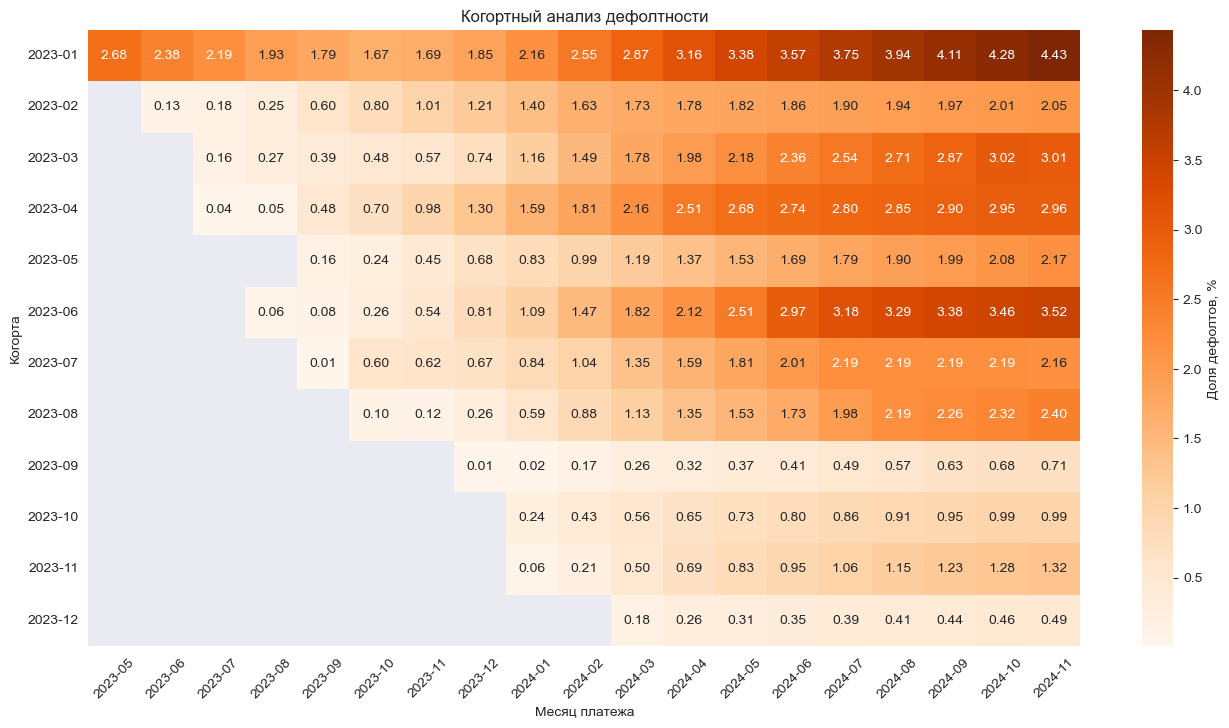

In [134]:
plt.figure(figsize=(16, 8)) 
sns.heatmap(defaulted_ratio,
            cmap='Oranges',
            annot=True,
            fmt=".2f",
            cbar_kws={'label': 'Доля дефолтов, %'})

plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.title("Когортный анализ дефолтности")
plt.xlabel("Месяц платежа")
plt.ylabel("Когорта")

plt.show()

- Первые "дефолты" начинаются в мае 2025-го - заемщики из январской когорты допустили просрочки
- Никто из заемщиков не допускает просрочки в первые два месяца (первый месяц - месяц выданного займа).
___

### Выводы

Главный вывод:
- Рейтинг сильно коррелирует со статусами платежа, займа и заемщика. Считаю, **статус заемщика** оказывает наибольшее влияние своевременную выплату: ниже статус заемщика -> выше вероятность просрочки/дефолта -> низкий рейтинг займа.

Дополнительно можно еще отметить такие моменты:
 
- Доля проблемных займов (просрочки, дефолты) растет. Данный факт вписывается в нынешние реалии (рост кредитных просрочек по стране). Возможно стоит более щепетильно подходить к выдаче займов, которые попадают под низкий рейтинг (16-18).
- Удивило распределение автоматического одобрения: в рейтингах (группы 7-12), в которых больше всего статусных заемщиков (gold+), примерно столько же автозаймов, сколько и в низких рейтингах. Возможно стоит быть более юзер-фрэндли для возможных заемщиков статуса gold+, т.к. для пользователя будет намного удобнее воспользоваться продуктом онлайн, а не ехать в офис/отдел.